Modeling: Mass Total + Source Inversion
=======================================

To fit a lens model to an interferometer dataset, we again perform lens modeling using a `NonLinearSearch`.
However, unlike CCD `Imaging` data, we fit the lens model in Fourier space, or the `uv-plane`, which circumvents issues
that arise when trying to fit CLEANED images of interferometer data.

A big challenge when fitting interferometer datasets is the huge quantity of data. Very long baseline ALMA or JVLA
observations observe in excess of *millions* of visibilities, which can make certain approaches to modeling
interferometer data extremely slow and expensive.

In this example, we fit an interferometer dataset consisting of 1 million visibilities, assuming a parametric
`EllipticalSersic` model for the source. In the `source_parametric.py` example we used a non-uniform fast Fourier
transform to make the lens modeling efficient. we'll be using this algorithm again, to ensure our model-fit is fast.

However, when we model the source using an `Inversion`, there is a second consideration that is key to run-time and
performance. The `Inversion` uses a linear algebra to solve for the reconstructed flux values of the source. The
traditional approach to this linear algebra stores all the data required as matrices on your hard-disk. Unfortunately,
when there are 1-100 million datapoints, this requires in excess of 10-1000GB of RAM and crippling the run-time!

Instead, **PyAutoLens** uses the library PyLops **PyLops** (https://pylops.readthedocs.io/en/latest/) to represent
the linear algebra calculation as a series of linear operators. These operators do not have to store the calculation
explicitly in memory, meaning the analysis of 1 million viibilities takes < 1GB of memory overall ensuring our lens
modeling is efficient!

In this script, we fit interferometer data with a strong lens model where:

 - The lens galaxy's light is omitted (and is not present in the simulated data).
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal` and `ExternalShear`.
 - The source galaxy's light is a parametric `VoronoiMagnification` `Pixelization` and `Constant`
   regularization.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Load the strong lens dataset `mass_sie__source_sersic` from .fits files.

Unlike the other example scripts, we use the `Interferometer` class to load this dataset, passing it paths to the .fits
files containing its visibilities, noise-map and uv_wavelengths.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

Using the dataset path, load the data (image, noise-map, PSF) as an `Interferometer` object from .fits files.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


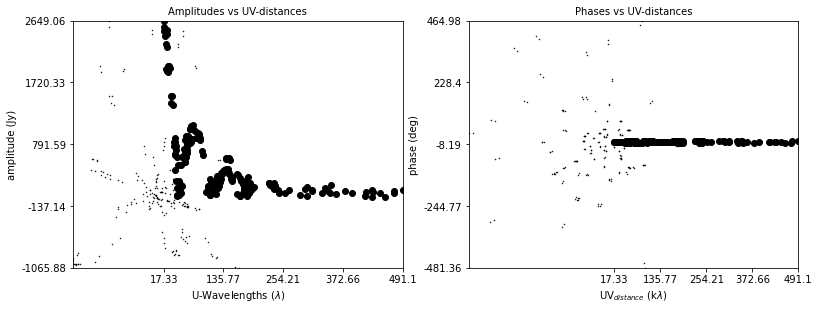

In [3]:
interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()

The perform a fit, we need two masks, firstly a ‘real-space mask’ which defines the grid the image of the lensed 
source galaxy is evaluated using.

In [4]:
real_space_mask = al.Mask2D.circular(
    shape_native=(200, 200), pixel_scales=0.05, radius=3.0
)

We also need a ‘visibilities mask’ which defining which visibilities are omitted from the chi-squared evaluation.

In [5]:
visibilities_mask = np.full(fill_value=False, shape=interferometer.visibilities.shape)

__Phase__

To perform lens modeling, we create a *PhaseInterferometer* object, which comprises:

   - The `GalaxyModel`'s used to fit the data.
   - The `SettingsPhase` which customize how the model is fitted to the data.
   - The `NonLinearSearch` used to sample parameter space.
   
Once we have create the phase, we `run` it by passing it the data and mask.

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens model is:

 - An `EllipticalIsothermal` `MassProfile` for the lens galaxy's mass [5 parameters].
 - An `EllipticalSersic` `LightProfile` for the source galaxy's light [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12.

In [6]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification,
    regularization=al.reg.Constant,
)

__Settings__

Next, we specify the *SettingsMaskedInterferometer*, which describes how the model is fitted to the data in the log 
likelihood function. Below, we specify:
 
 - That a regular `Grid2D` is used to fit create the model-image (in real space) when fitting the data 
   (see `autolens_workspace/examples/grids.py` for a description of grids).

 - The sub-grid size of this real-space grid.

 - The method used to Fourier transform this real-space image of the strong lens to the uv-plane, to compare directly
   to the visiblities. In this example, we use a non-uniform fast Fourier transform.

In [7]:
settings_masked_interferometer = al.SettingsMaskedInterferometer(
    grid_class=al.Grid2D, sub_size=2, transformer_class=al.TransformerNUFFT
)

We also specify the *SettingsInversion*, which describes how the `Inversion` fits the source `Pixelization` and 
with `Regularization`. 

This can perform the linear algebra calculation that performs the `Inversion` using two options: 

 - As matrices: this is numerically more accurate and does not approximate the `log_evidence` of the `Inversion`. For
  datasets of < 100 0000 visibilities we recommend that you use this option. However, for > 100 000 visibilities this
  approach requires excessive amounts of memory on your computer (> 16 GB) and thus becomes unfeasible. 
  
 - As linear operators: this numerically less accurate and approximates the `log_evidence` of the `Inversioon`. However,
 it is the only viable options for large visibility datasets. It does not represent the linear algebra as matrices in
 memory and thus makes the analysis of > 10 million visibilities feasible.

By default we use the linear operators approach.  

In [8]:
settings_inversion = al.SettingsInversion(use_linear_operators=True)

settings = al.SettingsPhaseInterferometer(
    settings_masked_interferometer=settings_masked_interferometer,
    settings_inversion=settings_inversion,
)

__Search__

The lens model is fitted to the data using a `NonLinearSearch`. In this example, we use the
nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/), with:

 - 50 live points.

The script `autolens_workspace/notebooks/interferometer/modeling/customize/non_linear_searches.py` gives a description 
of the types of non-linear searches that **PyAutoLens** supports. If you do not know what a `NonLinearSearch` 
is or how it operates, checkout chapters 1 and 2 of the HowToLens lecture series.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/interferometer/mass_sie__source_sersic/phase_mass[sie]_source[bulge]`.

In [9]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer", dataset_name),
    name="phase_mass[sie]_source[inversion]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [10]:
phase = al.PhaseInterferometer(
    search=search,
    real_space_mask=real_space_mask,
    galaxies=af.Collection(lens=lens, source=source),
    settings=settings,
)

We can now begin the fit by passing the dataset and visibilties mask to the phase, which will use the `NonLinearSearch` 
to fit the model to the data. 

The fit outputs visualization on-the-fly, so checkout the path 
`autolens_workspace/output/examples/phase_mass[sie]_source[bulge]` to see how your fit is doing!

In [11]:
result = phase.run(dataset=interferometer, mask=visibilities_mask)

INFO:root:phase_mass[sie]_source[inversion] already completed, skipping non-linear search.


The phase above returned a result, which, for example, includes the lens model corresponding to the maximum
log likelihood solution in parameter space.

In [12]:
print(result.max_log_likelihood_instance)

It also contains instances of the maximum log likelihood Tracer and FitImaging, which can be used to visualize
the fit.

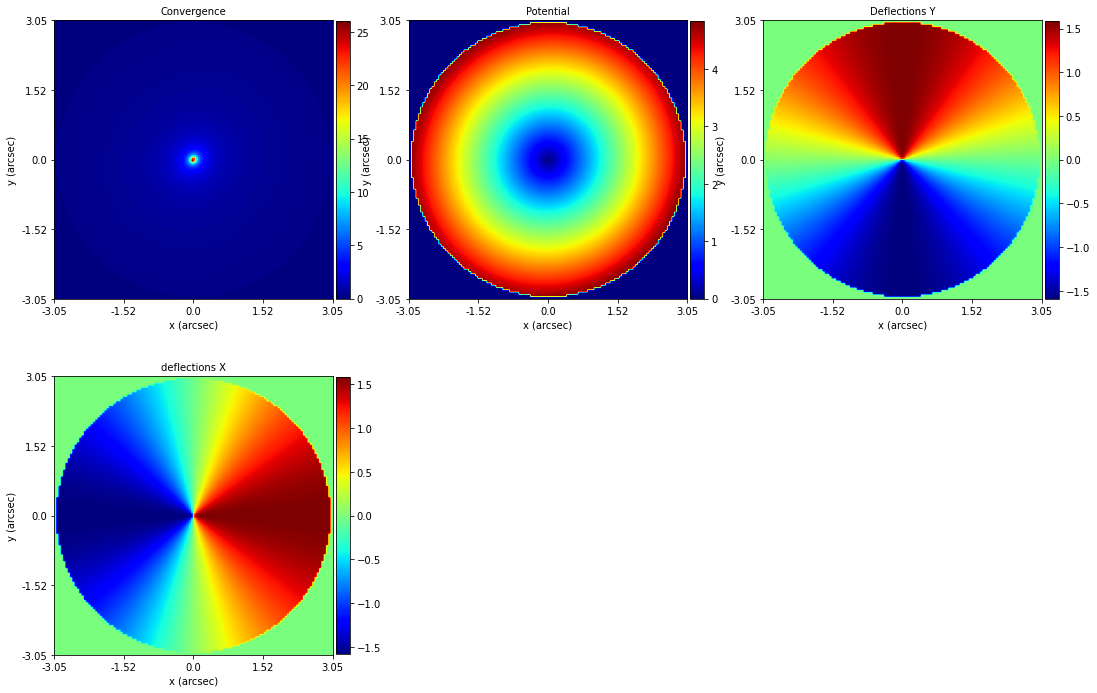

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


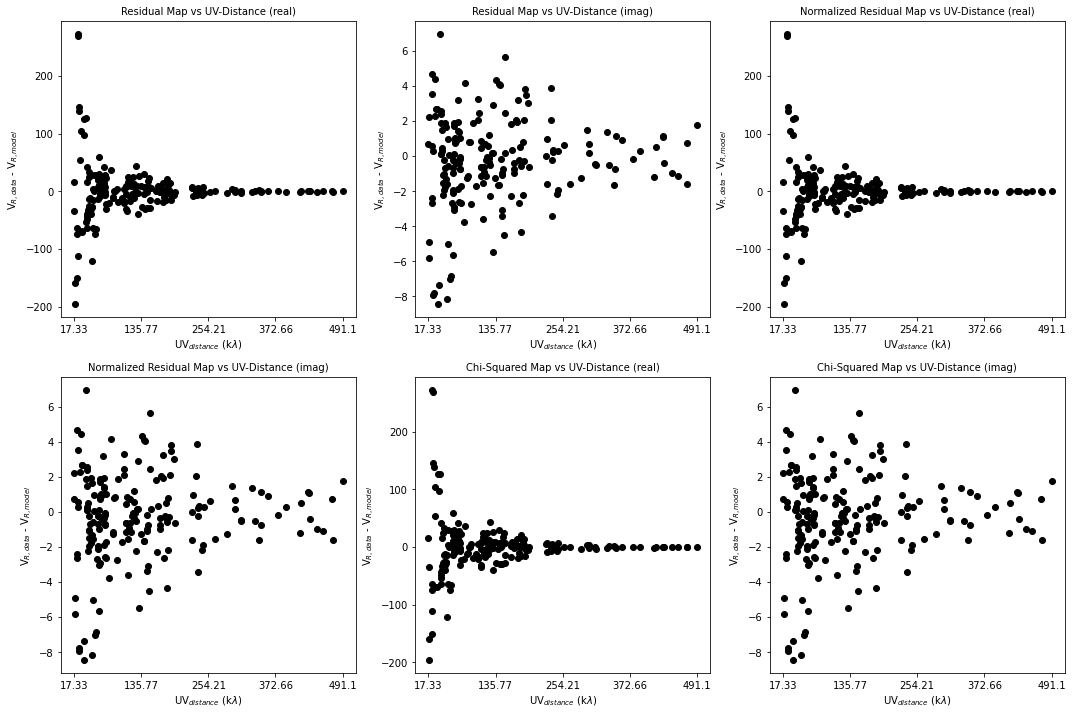

In [13]:
tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=real_space_mask.masked_grid_sub_1
)
tracer_plotter.subplot_tracer()

fit_interferometer_plotter = aplt.FitInterferometerPlotter(
    fit=result.max_log_likelihood_fit
)
fit_interferometer_plotter.subplot_fit_interferometer()

Checkout `autolens_workspace/notebooks/interferometer/modeling/results.py` for a full description of the result object.